In [26]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import sklearn as sk
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV

In [27]:
data = pd.read_csv('Hitters.csv')
data = data.dropna(subset=['Salary'])
data

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


# Part I: Different Model Specs
A. Regression without regularization

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression.

In [110]:
X = data.drop(['Salary'], axis=1)
y = data['Salary']

ct = ColumnTransformer(
    [
        ('standardize', StandardScaler(), make_column_selector(dtype_include=np.number)),
        ('dummify', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object))
    ],
    remainder= 'passthrough'
)

lr_pipline = Pipeline(
    [
        ('preprocessing', ct),
        ('regression', LinearRegression())
    ]
)

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

In [113]:
lr_model = lr_pipline.fit(X,y)

feature_names = lr_model.named_steps['preprocessing'].get_feature_names_out()
lr_coefs = lr_model.named_steps['regression'].coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefs})
coef_df.sort_values(by = 'Coefficient', key = abs, ascending= False).head(5)

,Feature,Coefficient
10,standardize__CRuns,480.747135
7,standardize__CAtBat,-391.038655
1,standardize__Hits,337.830479
0,standardize__AtBat,-291.094556
11,standardize__CRBI,260.689886


For every one standard deviation increase in career runs, predicted salary increases by $480,747.
For every one standard deviation increase in career at bats, predicted salary decreases by $391,038.
For every one standard deviation increase in hits in 1986, predicted salary increases by $337,830.
For every one standard deviation increase in at bats in 1986, predicted salary decreases by $291,094.
For every one standard deviation increase in career RBIs, predicted salary increases by $260,689.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [30]:
-cross_val_score(lr_pipline, X, y, cv = 5, scoring = "neg_mean_squared_error").mean().round(2)

121136.31

B. Ridge regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [31]:
ridge_pipeline = Pipeline(
    [
        ('preprocessing', ct),
        ('ridge', Ridge())
    ]
)


2. Use cross-validation to tune the lambda hyperparameter.

In [32]:
alpha_values = [0.001, 0.01, 0.1, 1, 10]
alphas = {'ridge__alpha': alpha_values}

gscv = GridSearchCV(ridge_pipeline, alphas, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X, y)


best_model_ridge = gscv.best_estimator_
best_lambda_ridge = gscv.best_params_['ridge__alpha']
print(f"Best lambda: {best_lambda_ridge}")

Best lambda: 1


3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

In [33]:
ridge_pipeline.set_params(ridge__alpha=1)
ridge_pipeline.fit(X, y)

feature_names = best_model_ridge.named_steps['preprocessing'].get_feature_names_out()
ridge_coefs = best_model_ridge.named_steps['ridge'].coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_coefs})
coef_df.sort_values(by = 'Coefficient', key = abs, ascending= False).head(5)

,Feature,Coefficient
10,standardize__CRuns,320.412169
1,standardize__Hits,296.645050
0,standardize__AtBat,-270.686441
7,standardize__CAtBat,-225.406548
12,standardize__CWalks,-184.423611


For every one standard deviation increase in career runs, predicted salary increases by $320,412.
For every one standard deviation increase in hits in 1986, predicted salary increases by $296,645.
For every one standard deviation increase in at bats in 1986, predicted salary decreases by $270,686.
For every one standard deviation increase in career at bats, predicted salary decreases by $225,406.
For every one standard deviation increase in career walks, predicted salary decreases by $184,423.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [34]:
-cross_val_score(ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean().round(2)

119144.43

C. Lasso Regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression.

In [35]:
lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso", Lasso())]
)

2. Use cross-validation to tune the lambda hyperparameter.

In [36]:
alphas = {'lasso__alpha': alpha_values}

gscv = GridSearchCV(lasso_pipeline, alphas, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X, y)

best_model_lasso = gscv.best_estimator_
best_lambda_lasso = gscv.best_params_['lasso__alpha']

print(f"Best lambda: {best_lambda_lasso}")

c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.983e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+07, toleranc

Best lambda: 1


3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

In [37]:
lasso_pipeline.set_params(lasso__alpha=10)
lasso_pipeline.fit(X, y)

feature_names = best_model_lasso.named_steps['preprocessing'].get_feature_names_out()
lasso_coefs = best_model_lasso.named_steps['lasso'].coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefs})
coef_df.sort_values(by = 'Coefficient', key = abs, ascending= False).head(5)

,Feature,Coefficient
10,standardize__CRuns,375.565034
1,standardize__Hits,304.358267
0,standardize__AtBat,-282.369623
11,standardize__CRBI,192.616442
12,standardize__CWalks,-189.643123


For every one standard deviation increase in career runs, predicted salary increases by $375,565.
For every one standard deviation increase in hits in 1986, predicted salary increases by $304,358.
For every one standard deviation increase in at bats in 1986, predicted salary decreases by $282,369.
For every one standard deviation increase in career RBIs, predicted salary increases by $192,616.
For every one standard deviation increase in career walks, predicted salary decreases by $189,643.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [38]:
-cross_val_score(lasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean().round(2)
-gscv.best_score_

119761.62831326024

D. Elastic Net

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [39]:
elastic_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic", ElasticNet())]
)

2. Use cross-validation to tune the lambda and alpha hyperparameters.

In [40]:
params = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10],
    "elastic__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

gscv = GridSearchCV(elastic_pipeline, params, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X, y)

best_elastic_model = gscv.best_estimator_
best_param_elastic = gscv.best_params_

best_score = gscv.best_score_

print(f"Best Parameters: {best_param_elastic}")

c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.030e+07, toleranc

Best Parameters: {'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.9}


3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

In [41]:
elastic_pipeline.set_params(elastic__alpha=0.1, elastic__l1_ratio=0.9)
elastic_pipeline.fit(X, y)

feature_names = best_elastic_model.named_steps['preprocessing'].get_feature_names_out()
elastic_coefs = best_elastic_model.named_steps['elastic'].coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': elastic_coefs})
coef_df.sort_values(by = 'Coefficient', key = abs, ascending= False).head(5)

,Feature,Coefficient
1,standardize__Hits,247.556168
0,standardize__AtBat,-231.507759
10,standardize__CRuns,223.037799
12,standardize__CWalks,-154.668795
11,standardize__CRBI,121.693876


For every one standard deviation increase in hits in 1986, predicted salary increases by $247,556.
For every one standard deviation increase in at bats in 1986, predicted salary decreases by $231,507.
For every one standard deviation increase in career runs, predicted salary increases by $223,037.
For every one standard deviation increase in career walks, predicted salary decreases by $154,668.
For every one standard deviation increase in career RBIs, predicted salary increases by $121,693.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [42]:
-cross_val_score(elastic_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean().round(2)

118969.49

# Part II: Variable Selection

Which numeric variable is most important.

In [43]:
#Hits is the most common significant variable from the above models.
X = data[['Hits']]
y = data['Salary']

In [87]:
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ['Hits'])
  ],
  remainder = "drop"
)

lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("regression", LinearRegression())]
).set_output(transform="pandas")

hits_lr_model = lr_pipeline.fit(X,y)

feature_names = hits_lr_model.named_steps['preprocessing'].get_feature_names_out()
hits_lr_coefs = hits_lr_model.named_steps['regression'].coef_

linear_regression_MSE = -cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
hits_lr_coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': hits_lr_coefs})
print(linear_regression_MSE.round(2))
hits_lr_coef_df

173088.97


,Feature,Coefficient
0,standardize__Hits,197.517786


In [54]:
ridge_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("regression", Ridge())
    ]
)

alpha_values = [0.001, 0.01, 0.1, 1, 10]
alphas = {'regression__alpha': alpha_values}

grid_search = GridSearchCV(ridge_pipeline, alphas, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['regression__alpha']
print(f"Best alpha: {best_alpha}")


Best alpha: 10


In [63]:
hits_ridge_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("regression", Ridge(alpha=10))
    ]
)

hits_ridge_MSE = -cross_val_score(hits_ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(hits_ridge_MSE.round(2))

hits_ridge_model = hits_ridge_pipeline.fit(X,y)

feature_names = hits_ridge_model.named_steps['preprocessing'].get_feature_names_out()
hits_ridge_coefs = hits_ridge_model.named_steps['regression'].coef_
hits_ridge_coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': hits_ridge_coefs})

hits_ridge_coefs_df

172755.98


,Feature,Coefficient
0,standardize__Hits,190.282702


In [77]:
lasso_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lasso", Lasso())
    ]
)

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]

alphas = {'lasso__alpha': alpha_values}

gscv = GridSearchCV(lasso_pipeline, alphas, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X, y)

best_model_lasso = gscv.best_estimator_
best_alpha = gscv.best_params_['lasso__alpha']

print(f"Best alpha: {best_alpha}")

hits_lasso_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lasso", Lasso(alpha=best_alpha))
    ]
)

hits_lasso_MSE = -cross_val_score(hits_lasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(hits_lasso_MSE.round(2))

hits_lasso_model = hits_lasso_pipeline.fit(X,y)

feature_names = hits_lasso_model.named_steps['preprocessing'].get_feature_names_out()
hits_lasso_coefs = hits_lasso_model.named_steps['lasso'].coef_
hits_lasso_coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': hits_lasso_coefs})

hits_lasso_coefs_df

Best alpha: 10
173061.63


,Feature,Coefficient
0,standardize__Hits,187.517786


In [85]:
elastic_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic", ElasticNet())]
)

params = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10, 100],
    "elastic__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

gscv = GridSearchCV(elastic_pipeline, params, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X, y)

best_elastic_model = gscv.best_estimator_
best_param_elastic = gscv.best_params_

best_score = gscv.best_score_

print(f"Best Parameters: {best_param_elastic}")

best_model = gscv.best_estimator_
best_alpha = gscv.best_params_['elastic__alpha']
best_l1_ratio = gscv.best_params_['elastic__l1_ratio']

hits_elastic_pipeline = Pipeline([
    ("preprocessing", ct),
    ("elastic", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio))
])

hits_elastic_MSE = -cross_val_score(hits_elastic_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(hits_elastic_MSE.round(2))

hits_elastic_model = hits_elastic_pipeline.fit(X, y)

feature_names = hits_elastic_model.named_steps['preprocessing'].get_feature_names_out()
hits_elastic_coefs = hits_elastic_model.named_steps['elastic'].coef_
hits_elastic_coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': hits_elastic_coefs})

hits_elastic_coefs_df

Best Parameters: {'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.1}
172603.55


,Feature,Coefficient
0,standardize__Hits,181.199803


In [89]:
cv_MSE = pd.DataFrame({
    "Model": ["Linear","Ridge", "Lasso", "Elastic"],
    "CV MSE": [linear_regression_MSE, hits_ridge_MSE, hits_lasso_MSE, hits_elastic_MSE]
})

cv_MSE

,Model,CV MSE
0,Linear,173088.972864
1,Ridge,172755.975523
2,Lasso,173061.634500
3,Elastic,172603.554302


As we can see above, the model with the lowest MSE after using cross validation is the elastic net model. This makes sense because the elastic net model is a mix of the both the ridge and the lasso models.

Using the best 5 numerical variables.

In [91]:
#Best 5 variables are Hits, At_Bat, CRuns, CWalks, and Runs.
X = data[['Hits', 'AtBat', 'CRuns', 'CWalks', 'Runs']]
y = data['Salary']

In [101]:
ct = ColumnTransformer(
  [  
    ("standardize", StandardScaler(), ['Hits', 'AtBat', 'CRuns', 'CWalks', 'Runs'])
  ],
  remainder = "drop"
)

lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("regression", LinearRegression())]
).set_output(transform="pandas")

five_lr_model = lr_pipeline.fit(X,y)

feature_names = five_lr_model.named_steps['preprocessing'].get_feature_names_out()
five_lr_coefs = five_lr_model.named_steps['regression'].coef_

five_lr_MSE = -cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
five_lr_coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': five_lr_coefs})
print(five_lr_MSE.round(2))

five_lr_coef_df

126613.56


,Feature,Coefficient
0,standardize__Hits,303.525671
1,standardize__AtBat,-217.652822
2,standardize__CRuns,221.331918
3,standardize__CWalks,-2.398545
4,standardize__Runs,56.249330


In [102]:
ridge_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("regression", Ridge())
    ]
)

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
alphas = {'regression__alpha': alpha_values}

grid_search = GridSearchCV(ridge_pipeline, alphas, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['regression__alpha']
print(f"Best alpha: {best_alpha}")

five_ridge_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("regression", Ridge(alpha=best_alpha))
    ]
)

five_ridge_MSE = -cross_val_score(five_ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(five_ridge_MSE.round(2))

five_ridge_model = five_ridge_pipeline.fit(X,y)

feature_names = five_ridge_model.named_steps['preprocessing'].get_feature_names_out()
five_ridge_coefs = five_ridge_model.named_steps['regression'].coef_
five_ridge_coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': five_ridge_coefs})

five_ridge_coefs_df

Best alpha: 1
126378.29


,Feature,Coefficient
0,standardize__Hits,278.977980
1,standardize__AtBat,-193.334924
2,standardize__CRuns,217.120289
3,standardize__CWalks,1.180678
4,standardize__Runs,56.920554


In [100]:
lasso_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lasso", Lasso())
    ]
)

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]

alphas = {'lasso__alpha': alpha_values}

gscv = GridSearchCV(lasso_pipeline, alphas, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X, y)

best_model_lasso = gscv.best_estimator_
best_alpha = gscv.best_params_['lasso__alpha']

print(f"Best alpha: {best_alpha}")

five_lasso_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lasso", Lasso(alpha=best_alpha))
    ]
)

five_lasso_MSE = -cross_val_score(five_lasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(five_lasso_MSE.round(2))

five_lasso_model = five_lasso_pipeline.fit(X,y)

feature_names = five_lasso_model.named_steps['preprocessing'].get_feature_names_out()
five_lasso_coefs = five_lasso_model.named_steps['lasso'].coef_
five_lasso_coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': five_lasso_coefs})

five_lasso_coefs_df

Best alpha: 1
126397.84


,Feature,Coefficient
0,standardize__Hits,279.057577
1,standardize__AtBat,-188.537226
2,standardize__CRuns,218.123610
3,standardize__CWalks,0.000000
4,standardize__Runs,51.702047


In [103]:
elastic_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic", ElasticNet())]
)

params = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10, 100],
    "elastic__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

gscv = GridSearchCV(elastic_pipeline, params, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X, y)

best_elastic_model = gscv.best_estimator_
best_param_elastic = gscv.best_params_

best_score = gscv.best_score_

print(f"Best Parameters: {best_param_elastic}")

best_model = gscv.best_estimator_
best_alpha = gscv.best_params_['elastic__alpha']
best_l1_ratio = gscv.best_params_['elastic__l1_ratio']

five_elastic_pipeline = Pipeline([
    ("preprocessing", ct),
    ("elastic", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio))
])

five_elastic_MSE = -cross_val_score(five_elastic_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(five_elastic_MSE.round(2))

five_elastic_model = five_elastic_pipeline.fit(X, y)

feature_names = five_elastic_model.named_steps['preprocessing'].get_feature_names_out()
five_elastic_coefs = five_elastic_model.named_steps['elastic'].coef_
five_elastic_coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': five_elastic_coefs})

five_elastic_coefs_df

Best Parameters: {'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.9}
126313.61


,Feature,Coefficient
0,standardize__Hits,246.175442
1,standardize__AtBat,-160.054718
2,standardize__CRuns,210.400388
3,standardize__CWalks,6.846237
4,standardize__Runs,57.071499


In [104]:
five_var_cv_MSE = pd.DataFrame({
    "Model": ["Linear","Ridge", "Lasso", "Elastic"],
    "CV MSE": [five_lr_MSE, five_ridge_MSE, five_lasso_MSE, five_elastic_MSE]
})

five_var_cv_MSE

,Model,CV MSE
0,Linear,126613.564856
1,Ridge,126378.291803
2,Lasso,126397.843140
3,Elastic,126313.614032


As seen by the table above, the MSE after doing cross validation is very similar for a lot of the models. The model with the lowest MSE is the elastic net model which is the same type of model that was the best fit when we were only using one variable.

Best five numerical variables and best categorical variable

In [118]:
#Best 5 variables are Hits, At_Bat, CRuns, CWalks, and Runs.
#Best categorical variable is division
X = data[['Hits', 'AtBat', 'CRuns', 'CWalks', 'Runs', 'Division']]
y = data['Salary']

In [129]:
ct = ColumnTransformer(
  [  
    ("standardize", StandardScaler(), ["Hits",'AtBat','CRuns','CWalks','Runs']),
    ("dummify", OneHotEncoder(sparse_output = False,handle_unknown="ignore"), ["Division"])
  ],
  remainder = "passthrough"
).set_output(transform="pandas")


ct_int = ColumnTransformer(
  [
    ("Hits_DivW", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),
    ("AtBat_DivW", PolynomialFeatures(interaction_only = True), ["standardize__AtBat", "dummify__Division_W"]),
    ("CRuns_DivW", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_W"]),
    ("CWalks_DivW", PolynomialFeatures(interaction_only = True), ["standardize__CWalks", "dummify__Division_W"]),
    ("Runs_DivW", PolynomialFeatures(interaction_only = True), ["standardize__Runs", "dummify__Division_W"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

int_lr_pipeline = Pipeline(
  [("preprocessing", ct),
   ("interact", ct_int),
  ("regression", LinearRegression())]
).set_output(transform="pandas")

int_lr_MSE = -cross_val_score(int_lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(int_lr_MSE.round(2))

int_lr_model = int_lr_pipeline.fit(X,y)

feature_names = int_lr_model.named_steps['preprocessing'].get_feature_names_out()
int_lr_coefs = int_lr_model.named_steps['regression'].coef_

125617.49


In [132]:
ridge_pipeline = Pipeline(
        [
        ("preprocessing", ct),
        ('interact', ct_int),
        ("regression", Ridge())
    ]
)

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
alphas = {'regression__alpha': alpha_values}

grid_search = GridSearchCV(ridge_pipeline, alphas, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['regression__alpha']
print(f"Best alpha: {best_alpha}")

int_ridge_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ('interact', ct_int),
        ("regression", Ridge(alpha=best_alpha))
    ]
)

int_ridge_model = int_ridge_pipeline.fit(X,y)

int_ridge_MSE = -cross_val_score(int_ridge_model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(int_ridge_MSE.round(2))


Best alpha: 0.1
125565.1


In [141]:
lasso_pipeline = Pipeline(
        [
        ("preprocessing", ct),
        ('interact', ct_int),
        ("regression", Lasso())
    ]
)

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
alphas = {'regression__alpha': alpha_values}

grid_search = GridSearchCV(lasso_pipeline, alphas, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['regression__alpha']
print(f"Best alpha: {best_alpha}")

int_lasso_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ('interact', ct_int),
        ("regression", Lasso(alpha=best_alpha))
   ]
)

int_lasso_model = int_lasso_pipeline.fit(X,y)

int_lasso_MSE = -cross_val_score(int_lasso_model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(int_lasso_MSE.round(2))

c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.234e+05, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.851e+05, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.424e+04, toleranc

Best alpha: 0.1
125531.65


In [147]:
elastic_pipeline = Pipeline(
    [("preprocessing", ct),
    ('interact', ct_int),
     ("elastic", ElasticNet())]
)

params = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10, 100],
    "elastic__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9,1]
}

gscv = GridSearchCV(elastic_pipeline, params, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X, y)

best_elastic_model = gscv.best_estimator_
best_param_elastic = gscv.best_params_

best_score = gscv.best_score_

print(f"Best Parameters: {best_param_elastic}")

best_model = gscv.best_estimator_
best_alpha = gscv.best_params_['elastic__alpha']
best_l1_ratio = gscv.best_params_['elastic__l1_ratio']

int_elastic_pipeline = Pipeline([
    ("preprocessing", ct),
    ('interact', ct_int),
    ("elastic", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio))
])

int_elastic_model = int_elastic_pipeline.fit(X, y)

int_elastic_MSE = -cross_val_score(int_elastic_model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(int_elastic_MSE.round(2))

c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.218e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.598e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e+07, toleranc

Best Parameters: {'elastic__alpha': 0.1, 'elastic__l1_ratio': 1}
125531.65


In [148]:
int_var_cv_MSE = pd.DataFrame({
    "Model": ["Linear","Ridge", "Lasso", "Elastic"],
    "CV MSE": [int_lr_MSE, int_ridge_MSE, int_lasso_MSE, int_elastic_MSE]
})

int_var_cv_MSE

,Model,CV MSE
0,Linear,125617.487703
1,Ridge,125565.100095
2,Lasso,125531.653674
3,Elastic,125531.653674


Here we see that the elastic net model and the lasso model have the same MSE after cross validation. This is because the elastic net found that the optimal value for the L1 ratio is 1.0. This means that the elastic net model behaves the same way as the lasso model, and therefore they have the same MSE.

# Part III: Discussion

## A. Ridge

When comparing the Ridge model to the ordinary regression model, we can see that the ridge model coefficients are smaller than the ordinary regression coefficients. This makes sense because one of the attributes of the ridge model is that it scales down large coefficient values. 

## B. LASSO

The alpha for the LASSO models different depending on the amount of variables in the given model. This makes sense because an attribute of LASSO models is that they give a penalty to models that have more variables since it looks to avoid overfitting the data. The MSE was also different for all of the LASSO models which makes sense becuase the models use a different number of variables in each of them. Models that have set of variables that explain salary better will have less MSE than models that have sets of variables with less good fits.

## C. Elastic Net

The elastic net always has the lowest MSE in all of the different comparisons. This is because elastic net is a combination of both the ridge and LASSO models and mixes the penalties that the two offer in order to get the lowest MSE. This can be seen in the interaction example where the elastic net model matched the MSE of the LASSO model which means that it found that the LASSO model already had the lowest MSE possible for that given set of variables.

# Part IV: Final Model

The best model, in terms of MSE, is the first elastic net model which was fit to all of the variables in the original data set. This model has an MSE of 118969.49

In [150]:

X = data.drop("Salary", axis = 1)
y = data["Salary"]


ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
        make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder = "passthrough")

final_elastic_pipeline = Pipeline([
        ("preprocessing", ct), 
        ("regression", ElasticNet(alpha = 0.1, l1_ratio = 0.9))])

final_model = final_elastic_pipeline.fit(X, y)

final_model_coefs = final_model.named_steps['regression'].coef_

feature_names = final_elastic_pipeline.named_steps['preprocessing'].get_feature_names_out()

final_elastic_coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': final_model_coefs})

final_elastic_coefs_df

,Feature,Coefficient
0,dummify__League_A,-27.879685
1,dummify__League_N,27.879984
2,dummify__Division_E,60.670592
3,dummify__Division_W,-60.671749
4,dummify__NewLeague_A,11.191580
5,dummify__NewLeague_N,-11.193473
6,standardize__AtBat,-231.507812
7,standardize__Hits,247.556146
8,standardize__HmRun,4.470922
9,standardize__Runs,-5.041668


In [155]:
y_preds = final_model.predict(X)

data['y_preds'] = y_preds

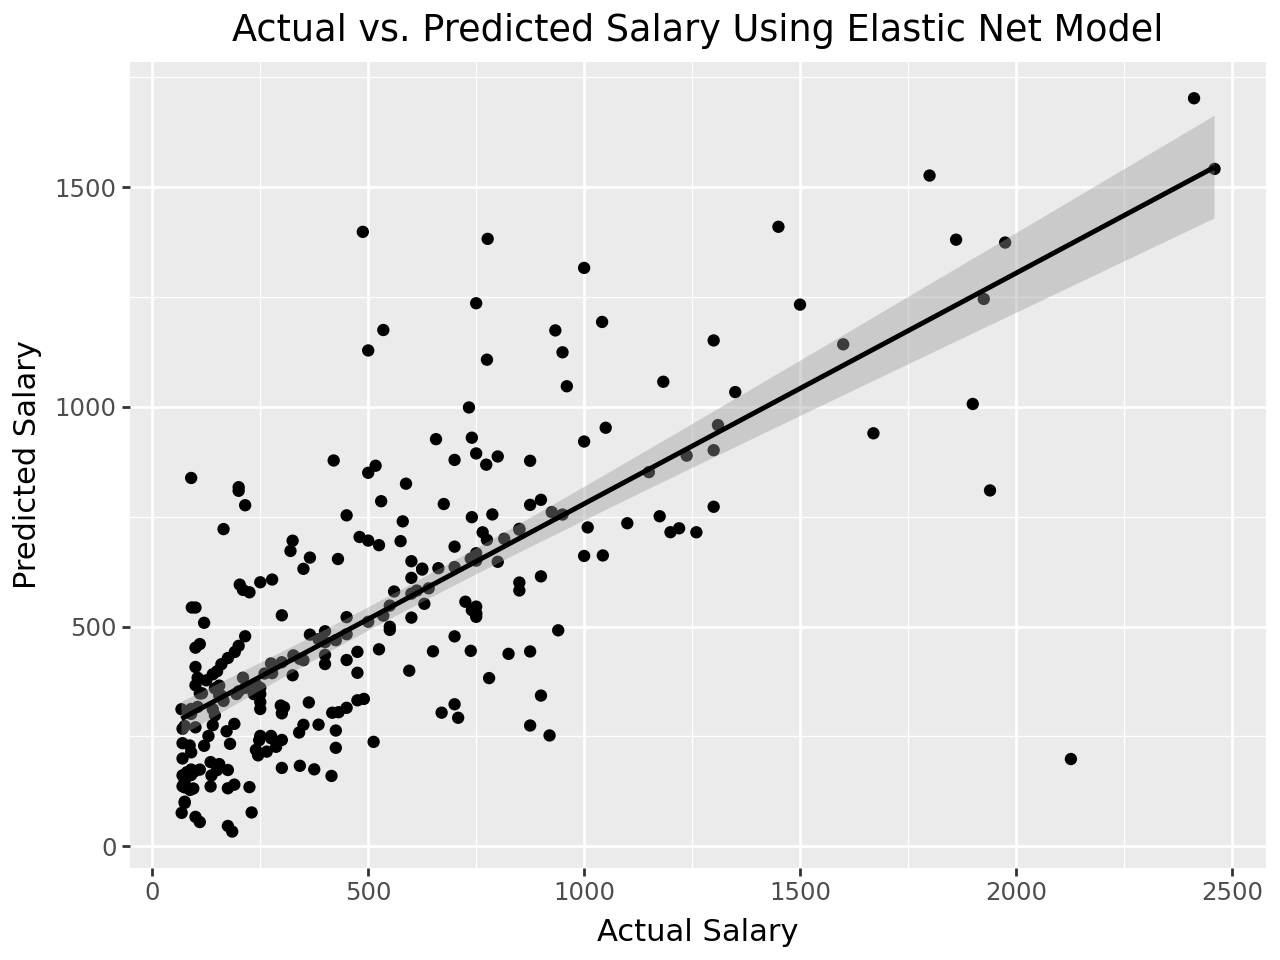

In [160]:
from plotnine import *

(ggplot(data, aes(x='Salary', y='y_preds')) +
geom_point() +
geom_smooth(method='lm') +
labs(x = 'Actual Salary', y = 'Predicted Salary', title = 'Actual vs. Predicted Salary Using Elastic Net Model')
)

The best model is an elastic net model with an lambda of .1 and an L1 ratio of 0.9. This model has the lowest MSE of any of the models used which indicates that it has the best predictive ability. The graph above shows a plot of the actual values of salary from the data set plotted alongside the values for salary that the elastic net model predicts.

# Appendix

For this lab assignment, chat GPT was used to assist with a few difficulites that I had in the code. Most of this was simpily trouble shooting and bug fixes that I asked for help with when I couldn't figure out what was incorrect with my code. Other than that, I used Chat GPT to help me get the coefficients extracted from the models and put into a data frame for good presentation because I belive that it looks much better than the standard coefficient output.